This notebook will run MHI with decay specified in config, with transforms on 
- MobileNet
- Resnet50
- EfficientNetB0

Dataset is 100 samples.<br>
DECAY = 0.09<br>
FRAME_SIZE = 20<br>
BINARY_THRESHOLD = 25 <br>

changes : <br>
- stratification for train/val <Br>
- adaptive thresholding <br>
- multi-channel decay <br>
- different sampling <br> 

In [1]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer albumentations

# Config

In [1]:
#all the required dependencies of the project
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import random
import wandb

from typing import Tuple
from collections import Counter
import albumentations as A
from tqdm import tqdm
from typing import List
import json
import tensorflow.keras as keras 
import tensorflow as tf

In [85]:
class CONFIG:
    ROOT_DIRECTORY = os.path.join("..","data","WLASL")
    JSON_FILE = "WLASL_v0.3.json"
    NSLT_FILE = "nslt_100.json"
    VIDEO_FOLDER = "videos"

    mean=[0, 0, 0]
    std=[1, 1, 1]
    DEBUG = True
    
    P_OF_TRANSFORM = 0.8
    P_OF_TRANSFORM_COLOR = 0.2
    
    SHIFT_LIMIT=0.1
    SCALE_LIMIT=0.05
    ROTATE_LIMIT=10
    
    # set to small, when prototyping, or 0 when deploying to cloud or PC with loads of RAM
    DATA_LIMIT = 100
    FRAME_SIZE = 20
    
    BATCH_SIZE = 4
    PORTION_OF_DATA_FOR_TRAINING = 0.8

    ROUND_DIGIT = 3
    #WANDB_RUN = "mediapipe-asl-dataset"
    DECAY = 0.09
    DECAY_R = 0.09
    DECAY_G = 0.09
    DECAY_B = 0.09
    THRESH = "adaptive"
    
    USE_WANDB = True

    WANDB_RUN = "MHI-CNN"
    
    SAMPLING = "uniform"
    SAMPLING_BIAS = 0.2
    VARIANCE = 0.15

## Utils

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
from wandb.keras import WandbMetricsLogger
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, run_name : str,
                train_ds, val_ds, dataset_name,
                max_lr = 1e-4, min_lr = 5e-5,
                T_max=50, epochs=100,
                decay = 0.09,USE_WANDB=True): 
   
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)

    callbacks = [checkpoint, cosine_annealer]

    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : min_lr, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : train_ds_len,
                                "val_size" : val_ds_len,
                                "unique_classes" : unique_labels_num, 
                                "video_length" : CONFIG.FRAME_SIZE,
                                "decay" : decay,
                                "SHIFT_LIMIT" : CONFIG.SHIFT_LIMIT,
                                "SCALE_LIMIT" : CONFIG.SCALE_LIMIT,
                                "ROTATE_LIMIT" : CONFIG.ROTATE_LIMIT,
                                "CACHEING" : dataset_name
                               })
        callbacks.append(WandbMetricsLogger())
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    #lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    #history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = CONFIG.BATCH_SIZE, callbacks=callbacks)
    #wandb.finish()
    if USE_WANDB:      
        wandb.finish()
    
    return history

# Cacheing V1

## Dataset definitions

In [91]:
from sklearn.model_selection import train_test_split
from math import ceil

class SignRecognitionDataset(keras.utils.Sequence):

    def __init__(self, max_start : int, max_end) -> None:
        # setup the paths
        video_path = os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.VIDEO_FOLDER)
        dataset_description = os.path.join(CONFIG.ROOT_DIRECTORY)

        # load the filepaths for videos
        self.video_paths = [os.path.join(video_path, file) for file in os.listdir(video_path)]

        # load the dataset config json
        self.config_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.JSON_FILE)) as f:
            self.config_json = json.load(f)

        # load the dataset json
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f)
        
        self.videos_paths = []
        self.paths_not_found = []
        self.labels = []
        self.start_frames = []
        self.end_frames = []
       
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f) 

        for el in tqdm(self.dataset_json.items()):
            video_id, properties = el[0], el[1]
            path = os.path.join(video_path, video_id + ".mp4")
            
            if not os.path.exists(path):
                self.paths_not_found.append(path)
                continue

            subset = properties["subset"]
            label, start, end = properties["action"]
            
            if start > max_start:
                continue
                
            if end > max_end:
                continue
            
            self.videos_paths.append(path)
            self.labels.append(label)
            self.start_frames.append(start)
            self.end_frames.append(end)
    
        self.videos_paths = np.array(self.video_paths)
        self.paths_not_found = np.array(self.paths_not_found)
        self.labels = np.array(self.labels)
        self.start_frames = np.array(self.start_frames)
        self.end_frames = np.array(self.end_frames)

        self.unique_labels = np.unique(self.labels)
        
    
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return traj
    
    def __len__(self):
        return len(self.videos_paths)

    def __getitem__(self, idx):
        path, label = self.videos_paths[idx], self.labels[idx]
        trajectory = SignRecognitionDataset.get_video(path)
        
        return self.preprocess_trajectory(trajectory), label

    def permutate(self):
        l = len(self.videos_paths)
        mask = np.arange(l)
        np.random.shuffle(mask)
        
        self.videos_paths = np.array(self.videos_paths)[mask]
        self.labels = np.array(self.labels)[mask]
        self.start_frames = np.array(self.start_frames)[mask]
        self.end_frames = np.array(self.end_frames)[mask]
        
    def sort_by_size(self):
        c = Counter(self.labels)
        _mask = sorted([ (10000 * c[l] + l, i) for i, l in enumerate(self.labels)])[::-1]
        mask_by_size = np.array([el[1] for el in _mask])

        self.video_paths        = np.array(self.video_paths)[mask_by_size]
        self.labels             = np.array(self.labels)[mask_by_size]
        self.start_frames       = np.array(self.start_frames)[mask_by_size]
        self.end_frames         = np.array(self.end_frames)[mask_by_size]

    def crop_video(self, trajectory : np.array) -> np.array:
        cropped = trajectory
        
        if self.FRAME_SIZE != 0:
            frame_size = len(trajectory)
            start = 0 
            
            if frame_size > self.FRAME_SIZE:
                if CONFIG.SAMPLING:
                    start = np.random.randint(0, frame_size - self.FRAME_SIZE)
                else:
                    mean = CONFIG.SAMPLING_BIAS * (frame_size - self.FRAME_SIZE)
                    variance = CONFIG.VARIANCE  * (frame_size - self.FRAME_SIZE)                    
                    start = max(min(variance * np.random.randn() + mean, frame_size-self.FRAME_SIZE), 0)
                    

            cropped = trajectory[start: (start + self.FRAME_SIZE)]
                    
            if len(cropped) < self.FRAME_SIZE:
                necessary = self.FRAME_SIZE - len(cropped)
                t, h, w, c = trajectory.shape
                cropped = np.concatenate([cropped, np.zeros((necessary, h, w, c))], axis= 0)
                
            return cropped
                        
        return trajectory
                
    @staticmethod
    def get_video(video_path : str) -> List[np.ndarray]:

        if not os.path.exists(video_path):
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_array = np.array(frame)
                frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
            else:
                break

        cap.release()
        return np.array(frames)

    @staticmethod
    def rescale_video(frames : np.ndarray, desired_shape) -> np.ndarray:
        refined = []
        for img in frames: 
            y, x, c = img.shape
            cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
            scaled = cv2.resize(cropped, desired_shape)
            refined.append(scaled)
    
        return np.array(refined)
        
class SignRecognitionDatasetMHICached(SignRecognitionDataset):

    def __init__(self, max_start: int, max_end, 
                 per_image_transform=None,
                 after_MHI_transform=None,
                 scaled_resolution : Tuple[int]= (224, 224),
                 frame_size:int=CONFIG.FRAME_SIZE,
                 data_limit : int = CONFIG.DATA_LIMIT,
                 decay : float = 0.7,
                 threshold_method : str = CONFIG.THRESH,
                 threshold_val : float = 25,
                 kernel_size : int = 11,
                 by_size=True,
                 train_val_split:float=CONFIG.PORTION_OF_DATA_FOR_TRAINING,
                 split:str="train") -> None:
        super().__init__(max_start, max_end)
        self.scaled_resolution = scaled_resolution
        self.DATA_LIMIT = data_limit
        self.by_size = by_size
        self.per_image_transform = per_image_transform
        self.after_MHI_transform = after_MHI_transform
        self.FRAME_SIZE = frame_size
        self.decay = decay
        self.threshold_method = threshold_method
        self.threshold_val = threshold_val
        self.kernel_size = kernel_size
        
        self.keywords = ["image" ] + list(str(i) for i in range(frame_size-1))
        
        self.sort_by_size()
        
        if self.DATA_LIMIT > 0:
            self.video_paths        = self.video_paths[:self.DATA_LIMIT]
            self.labels             = self.labels[:self.DATA_LIMIT]
            self.start_frames       = self.start_frames[:self.DATA_LIMIT]
            self.end_frames         = self.end_frames[:self.DATA_LIMIT]
        
        
        self.dataset = np.concatenate([np.array(self.video_paths).reshape(-1, 1),
                                       np.array(self.labels).reshape(-1, 1)], axis=1)   
        
        self.unique_labels = np.unique(self.dataset[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
        train_ds, val_ds = train_test_split(self.dataset, train_size=train_val_split, 
                                            random_state=42, stratify=self.dataset[:, 1])
                                                            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds
        
        else: 
            raise Exception("")

        self.cache_data()

    
    def cache_data(self):    
        self.cached_X = []
        self.cached_Y = []
        
        for i,el in tqdm(enumerate(self.dataset), desc="Cacheing"):
            
            trajectory = SignRecognitionDataset.get_video(el[0])  
            trajectory, label = self.preprocess_trajectory(trajectory), el[1]            
            
            onehotencoded = np.zeros(len(self.unique_labels))
            onehotencoded[self.label_2_id[label]] = 1.0
                    
            self.cached_X.append(trajectory)
            self.cached_Y.append(onehotencoded)
        
        
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return SignRecognitionDataset.rescale_video(traj, self.scaled_resolution)
        
    def __len__(self):
        return len(self.dataset)

    def postprocess_trajectory(self, traj : np.ndarray) -> np.ndarray:
        # timeframe, Width, height, channels
        ts, w, h, c = traj.shape
        
        mhi = np.zeros((w, h))
                
        for i in range(1, ts):
            frame_diff = np.abs(traj[i] - traj[i-1])
            gray_diff = (255 * np.mean(frame_diff, axis=2)).astype(np.uint8)
            
            # BINARY
            if self.threshold_method.lower() == "binary":
                _, binary_diff = cv2.threshold(gray_diff, self.threshold_val, 255, cv2.THRESH_BINARY)

            else:
                # Adaptive 
                binary_diff = cv2.adaptiveThreshold(gray_diff, 255., cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                    cv2.THRESH_BINARY_INV, self.kernel_size, 2)
    

            binary_diff = binary_diff.astype(np.float32) / 255.
            
            mhi = mhi * (1.0 - self.decay) + binary_diff

        mhi = (mhi - np.mean(mhi)) / np.std(mhi)

        mhi = mhi.reshape(mhi.shape[0], mhi.shape[1], 1)
        return np.concatenate([mhi,mhi,mhi], axis=2)


    def __getitem__(self, idx):
        
        trajectory, label = self.crop_video(self.cached_X[idx]), self.cached_Y[idx]
        
        if self.per_image_transform is not None:            
            frames = {self.keywords[i] : frame for i, frame in enumerate(trajectory)}
            processing = self.per_image_transform(**frames)       

            trajectory = np.array([processing[kw] for kw in self.keywords])    

        return self.postprocess_trajectory(trajectory), label

## Dataset Creation

In [92]:
import matplotlib.pyplot as plt 

transform = A.Compose(
    [
        A.Normalize(mean=CONFIG.mean, std=CONFIG.std),
        #A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        #A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
        #                   scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
        #A.RandomBrightnessContrast(p=CONFIG.P_OF_TRANSFORM_COLOR),
        #A.RGBShift(p=CONFIG.P_OF_TRANSFORM_COLOR),
    ],
    additional_targets={str(i) : "image" for i in range(CONFIG.FRAME_SIZE)}
)

train_ds = SignRecognitionDatasetMHICached(1, 150, per_image_transform=transform, decay=0.1,
                                           kernel_size=7, split="train")
val_ds = SignRecognitionDatasetMHICached(1, 150, per_image_transform=transform, decay=0.1,
                                         kernel_size=7, split="val")

train_ds_len = len(train_ds)
val_ds_len = len(val_ds)
unique_labels_num = len(train_ds.unique_labels)

print(f"size of train_ds = {len(train_ds)}, size of val_ds = {len(val_ds)}")
x, y = next(iter(train_ds))
x_shape = x.shape
y_shape = y.shape
print(x_shape, y_shape)

def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_ds)):
        X_batch, Y_batch = train_ds[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_ds)):
        X_batch, Y_batch = val_ds[i]
        yield X_batch, Y_batch        

train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

100%|██████████| 2038/2038 [00:00<00:00, 45491.75it/s]
Cacheing: 80it [00:12,  6.29it/s]
100%|██████████| 2038/2038 [00:00<00:00, 45768.46it/s]
Cacheing: 20it [00:02,  6.86it/s]

size of train_ds = 80, size of val_ds = 20
(224, 224, 3) (7,)


In [93]:
train_labels = []
val_labels = []

for x, y in train_dataset:
    labels = np.argmax(y, axis=1)
    for l in labels:
        train_labels.append(l)
        
for x, y in val_dataset:
    labels = np.argmax(y, axis=1)
    for l in labels:
        val_labels.append(l)

C:\Users\mlewand\AppData\Local\Temp\ipykernel_972\2809329893.py:261: RuntimeWarning: invalid value encountered in divide
  mhi = mhi.reshape(mhi.shape[0], mhi.shape[1], 1) / np.max(mhi)


(array([3., 3., 0., 3., 0., 3., 3., 0., 3., 2.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

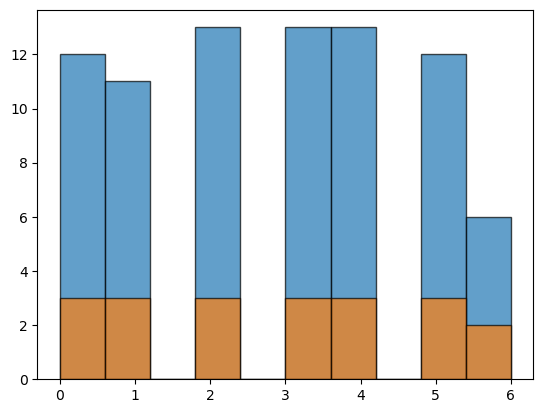

In [94]:
plt.hist(train_labels, alpha=0.7, edgecolor="black")
plt.hist(val_labels, alpha=0.7,  edgecolor="black")

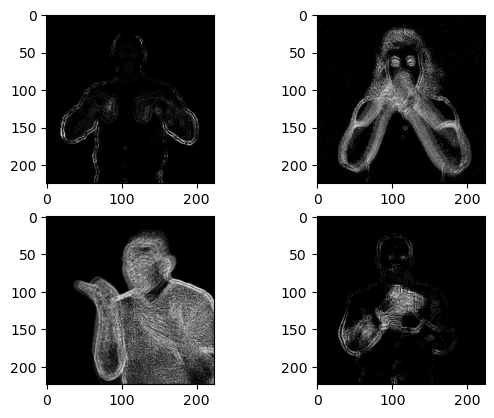

: 

In [95]:
x,y = next(iter(train_dataset))
plt.subplot(2, 2, 1)
plt.imshow(x[0])
plt.subplot(2, 2, 2)
plt.imshow(x[1])
plt.subplot(2, 2, 3)
plt.imshow(x[2])
plt.subplot(2, 2, 4)
plt.imshow(x[3])
plt.show()

## Run experimenets

### MobileNetV3

In [9]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.MobileNetV3Small(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

hist = keras_train(model, run_name="C1_MobileNetV3Small_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="transforms_for_video_no_transforms", 
            max_lr = 0.5e-4, 
            min_lr = 1e-5,
            T_max=10, 
            epochs=50,
            filepath=os.path.join("models", "MHI_MobileNetV3Small_no_transforms.keras"), 
            USE_WANDB=CONFIG.USE_WANDB)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mlewand (mlewand7). Use `wandb login --relogin` to force relogin


AttributeError: 'Adam' object has no attribute 'lr'

In [ ]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.MobileNetV3Small(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, run_name="C1_MobileNetV3Small_2_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="transforms_for_video_no_transforms", 
            max_lr = 0.5e-4, 
            min_lr = 1e-5,
            T_max=251, 
            epochs=500,
            filepath=os.path.join("models", "MHI_MobileNetV3Small_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

### Resnet50

In [ ]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.ResNet50(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))


keras_train(model, run_name="C1_Resnet50_augmentation_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="transforms_for_video_no_transforms", 
            max_lr = 0.5e-4, 
            min_lr = 1e-5,
            T_max=51, 
            epochs=100,
            filepath=os.path.join("models", "MHI_Resnet50_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

Epoch 1/100
     20/Unknown - 32s 187ms/step - loss: 2.7425 - categorical_accuracy: 0.1125

2024-04-15 12:42:08.295078: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8940206431827680969


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 50s 1s/step - loss: 2.7425 - categorical_accuracy: 0.1125 - val_loss: 3.4292 - val_categorical_accuracy: 0.1000
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.3185 - categorical_accuracy: 0.1625INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 21s 1s/step - loss: 2.3185 - categorical_accuracy: 0.1625 - val_loss: 2.3697 - val_categorical_accuracy: 0.2000
Epoch 3/100
20/20 [==============================] - 5s 248ms/step - loss: 2.1710 - categorical_accuracy: 0.1250 - val_loss: 2.5196 - val_categorical_accuracy: 0.1500
Epoch 4/100
20/20 [==============================] - 5s 251ms/step - loss: 1.9684 - categorical_accuracy: 0.3000 - val_loss: 3.2079 - val_categorical_accuracy: 0.2000
Epoch 5/100
20/20 [==============================] - 5s 242ms/step - loss: 1.9586 - categorical_accuracy: 0.2750 - val_loss: 3.1360 - val_categorical_accuracy: 0.1000
Epoch 6/100
20/20 [==============================] - 5s 248ms/step - loss: 1.6959 - categorical_accuracy: 0.3250 - val_loss: 3.4383 - val_categorical_accuracy: 0.1500
Epoch 7/100
20/20 [==============================] - 5s 245ms/step - loss: 1.8800 - categorical_accuracy: 0.3125 - val_loss: 3.4253 - val_categorical_accuracy: 0.0500
Epoch 8/100


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 20s 1s/step - loss: 0.8915 - categorical_accuracy: 0.6875 - val_loss: 2.2654 - val_categorical_accuracy: 0.3500
Epoch 23/100
20/20 [==============================] - 5s 248ms/step - loss: 0.7608 - categorical_accuracy: 0.7500 - val_loss: 2.4483 - val_categorical_accuracy: 0.2500
Epoch 24/100
20/20 [==============================] - 5s 243ms/step - loss: 0.6526 - categorical_accuracy: 0.8375 - val_loss: 3.1179 - val_categorical_accuracy: 0.1000
Epoch 25/100
20/20 [==============================] - 5s 248ms/step - loss: 0.8073 - categorical_accuracy: 0.7375 - val_loss: 3.7050 - val_categorical_accuracy: 0.2500
Epoch 26/100
20/20 [==============================] - 5s 238ms/step - loss: 0.6973 - categorical_accuracy: 0.7875 - val_loss: 3.9360 - val_categorical_accuracy: 0.2000
Epoch 27/100
20/20 [==============================] - 5s 242ms/step - loss: 0.7814 - categorical_accuracy: 0.7250 - val_loss: 3.5362 - val_categorical_accuracy: 0.2000
Epoch 2

INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 21s 1s/step - loss: 0.2241 - categorical_accuracy: 0.9250 - val_loss: 5.5460 - val_categorical_accuracy: 0.4000
Epoch 71/100
 9/20 [============>.................] - ETA: 2s - loss: 0.0332 - categorical_accuracy: 1.0000

In [32]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.ResNet50(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))


keras_train(model, run_name="C1_Resnet50_augmentation_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="transforms_for_video_no_transforms", 
            max_lr = 0.5e-4, 
            min_lr = 1e-5,
            T_max=251, 
            epochs=500,
            filepath=os.path.join("models", "MHI_Resnet50_2_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

Epoch 1/500
     20/Unknown - 31s 182ms/step - loss: 2.2559 - categorical_accuracy: 0.1625INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


20/20 [==============================] - 48s 1s/step - loss: 2.2559 - categorical_accuracy: 0.1625 - val_loss: 2.8161 - val_categorical_accuracy: 0.1000
Epoch 2/500
20/20 [==============================] - ETA: 0s - loss: 2.2016 - categorical_accuracy: 0.1500INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


20/20 [==============================] - 21s 1s/step - loss: 2.2016 - categorical_accuracy: 0.1500 - val_loss: 2.2531 - val_categorical_accuracy: 0.2000
Epoch 3/500
20/20 [==============================] - 5s 241ms/step - loss: 2.0535 - categorical_accuracy: 0.3000 - val_loss: 2.3415 - val_categorical_accuracy: 0.0500
Epoch 4/500
20/20 [==============================] - 5s 244ms/step - loss: 1.8420 - categorical_accuracy: 0.3375 - val_loss: 2.0719 - val_categorical_accuracy: 0.2000
Epoch 5/500
20/20 [==============================] - 5s 254ms/step - loss: 1.7283 - categorical_accuracy: 0.3250 - val_loss: 2.5633 - val_categorical_accuracy: 0.1500
Epoch 6/500
20/20 [==============================] - 5s 245ms/step - loss: 1.5408 - categorical_accuracy: 0.4000 - val_loss: 2.9205 - val_categorical_accuracy: 0.0500
Epoch 7/500
20/20 [==============================] - ETA: 0s - loss: 1.5710 - categorical_accuracy: 0.4375INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


20/20 [==============================] - 21s 1s/step - loss: 1.5710 - categorical_accuracy: 0.4375 - val_loss: 2.4161 - val_categorical_accuracy: 0.2500
Epoch 8/500
20/20 [==============================] - 5s 255ms/step - loss: 1.5095 - categorical_accuracy: 0.4750 - val_loss: 4.6276 - val_categorical_accuracy: 0.2000
Epoch 9/500
20/20 [==============================] - 5s 245ms/step - loss: 1.2043 - categorical_accuracy: 0.5750 - val_loss: 4.0033 - val_categorical_accuracy: 0.1500
Epoch 10/500
20/20 [==============================] - 5s 250ms/step - loss: 1.3818 - categorical_accuracy: 0.4625 - val_loss: 2.5415 - val_categorical_accuracy: 0.1000
Epoch 11/500
20/20 [==============================] - 5s 245ms/step - loss: 1.4359 - categorical_accuracy: 0.4500 - val_loss: 2.9595 - val_categorical_accuracy: 0.1500
Epoch 12/500
20/20 [==============================] - 5s 242ms/step - loss: 1.1256 - categorical_accuracy: 0.5875 - val_loss: 2.9570 - val_categorical_accuracy: 0.2000
Epoch 13/

INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


20/20 [==============================] - 21s 1s/step - loss: 0.7793 - categorical_accuracy: 0.7250 - val_loss: 3.3272 - val_categorical_accuracy: 0.3000
Epoch 24/500
20/20 [==============================] - 5s 247ms/step - loss: 0.8156 - categorical_accuracy: 0.7125 - val_loss: 4.3214 - val_categorical_accuracy: 0.1500
Epoch 25/500
20/20 [==============================] - 5s 247ms/step - loss: 0.8565 - categorical_accuracy: 0.7250 - val_loss: 4.9854 - val_categorical_accuracy: 0.1500
Epoch 26/500
20/20 [==============================] - 5s 247ms/step - loss: 0.7412 - categorical_accuracy: 0.7375 - val_loss: 3.4444 - val_categorical_accuracy: 0.2500
Epoch 27/500
20/20 [==============================] - 5s 245ms/step - loss: 0.5364 - categorical_accuracy: 0.8625 - val_loss: 3.9056 - val_categorical_accuracy: 0.0500
Epoch 28/500
20/20 [==============================] - 5s 242ms/step - loss: 0.7214 - categorical_accuracy: 0.7375 - val_loss: 4.0813 - val_categorical_accuracy: 0.3000
Epoch 2

INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


20/20 [==============================] - 22s 1s/step - loss: 0.6302 - categorical_accuracy: 0.7875 - val_loss: 3.0000 - val_categorical_accuracy: 0.3500
Epoch 30/500
20/20 [==============================] - 5s 243ms/step - loss: 0.6068 - categorical_accuracy: 0.8125 - val_loss: 3.7095 - val_categorical_accuracy: 0.2000
Epoch 31/500
20/20 [==============================] - 5s 251ms/step - loss: 0.5476 - categorical_accuracy: 0.8375 - val_loss: 3.9564 - val_categorical_accuracy: 0.2000
Epoch 32/500
20/20 [==============================] - 5s 246ms/step - loss: 0.5385 - categorical_accuracy: 0.8500 - val_loss: 4.1791 - val_categorical_accuracy: 0.2500
Epoch 33/500
20/20 [==============================] - ETA: 0s - loss: 0.6450 - categorical_accuracy: 0.7875INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


20/20 [==============================] - 21s 1s/step - loss: 0.6450 - categorical_accuracy: 0.7875 - val_loss: 3.1386 - val_categorical_accuracy: 0.4000
Epoch 34/500
20/20 [==============================] - 5s 248ms/step - loss: 0.6010 - categorical_accuracy: 0.8000 - val_loss: 3.9849 - val_categorical_accuracy: 0.2000
Epoch 35/500
20/20 [==============================] - 5s 239ms/step - loss: 0.3713 - categorical_accuracy: 0.9000 - val_loss: 2.7535 - val_categorical_accuracy: 0.2000
Epoch 36/500
20/20 [==============================] - 5s 248ms/step - loss: 0.2770 - categorical_accuracy: 0.9000 - val_loss: 2.1210 - val_categorical_accuracy: 0.4000
Epoch 37/500
20/20 [==============================] - 5s 248ms/step - loss: 0.5238 - categorical_accuracy: 0.8250 - val_loss: 2.4425 - val_categorical_accuracy: 0.3500
Epoch 38/500
20/20 [==============================] - 5s 244ms/step - loss: 0.4729 - categorical_accuracy: 0.8500 - val_loss: 5.8577 - val_categorical_accuracy: 0.1500
Epoch 3

INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


20/20 [==============================] - 21s 1s/step - loss: 0.0559 - categorical_accuracy: 0.9750 - val_loss: 3.2410 - val_categorical_accuracy: 0.4500
Epoch 85/500
20/20 [==============================] - 5s 250ms/step - loss: 0.0351 - categorical_accuracy: 1.0000 - val_loss: 4.8353 - val_categorical_accuracy: 0.2500
Epoch 86/500
20/20 [==============================] - 5s 241ms/step - loss: 0.0766 - categorical_accuracy: 0.9875 - val_loss: 3.9569 - val_categorical_accuracy: 0.2500
Epoch 87/500
20/20 [==============================] - 5s 247ms/step - loss: 0.0994 - categorical_accuracy: 0.9750 - val_loss: 3.5450 - val_categorical_accuracy: 0.1500
Epoch 88/500
20/20 [==============================] - 5s 237ms/step - loss: 0.0467 - categorical_accuracy: 0.9875 - val_loss: 4.7898 - val_categorical_accuracy: 0.2000
Epoch 89/500
20/20 [==============================] - 5s 244ms/step - loss: 0.0294 - categorical_accuracy: 0.9875 - val_loss: 3.0480 - val_categorical_accuracy: 0.1500
Epoch 9

INFO:tensorflow:Assets written to: models/MHI_Resnet50_2.tf/assets


20/20 [==============================] - 22s 1s/step - loss: 0.0435 - categorical_accuracy: 0.9875 - val_loss: 3.9502 - val_categorical_accuracy: 0.5000
Epoch 107/500
20/20 [==============================] - 5s 241ms/step - loss: 0.0393 - categorical_accuracy: 0.9875 - val_loss: 3.4501 - val_categorical_accuracy: 0.3500
Epoch 108/500
20/20 [==============================] - 5s 249ms/step - loss: 0.0864 - categorical_accuracy: 0.9750 - val_loss: 3.5222 - val_categorical_accuracy: 0.2000
Epoch 109/500
20/20 [==============================] - 5s 245ms/step - loss: 0.0203 - categorical_accuracy: 1.0000 - val_loss: 3.8761 - val_categorical_accuracy: 0.2000
Epoch 110/500
20/20 [==============================] - 5s 258ms/step - loss: 0.0253 - categorical_accuracy: 0.9875 - val_loss: 4.1685 - val_categorical_accuracy: 0.2500
Epoch 111/500
20/20 [==============================] - 5s 252ms/step - loss: 0.0717 - categorical_accuracy: 0.9625 - val_loss: 5.0495 - val_categorical_accuracy: 0.3500
Ep

epoch/categorical_accuracy,▁▅▅▆▇██▇████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
epoch/loss,█▅▄▃▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▄▁▆▄▄▄▃▅█▆▆▆▆▇▅█▇▆▄▅██▄▄▅▄▆▇▅▅▆▅▇▄▆▇▅▅▃▇
epoch/val_loss,▁▄▅▄█▄▇▆▂█▄▄▃▄▅▆▆▃▄▅▄▅█▇▄▄▇▄▅▆▆▆▄▅▄▃▅▆▆▄
epoch/categorical_accuracy,1.0
epoch/epoch,499
epoch/learning_rate,1e-05
epoch/loss,0.00038
epoch/val_categorical_accuracy,0.25


### EfficientNetB0

In [ ]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.EfficientNetB0(input_shape = MHI_SHAPE,
                                                include_top = False,
                                                weights = None,
                                                pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, run_name="C1_EfficientNetB0_augmentation_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="transforms_for_video_no_transforms", 
            max_lr = 1e-4, 
            min_lr = 2.5e-5,
            T_max=501, 
            epochs=1000,
            filepath=os.path.join("models", "EfficientNetB0_2_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

Epoch 1/1000


2024-04-15 15:34:08.578734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


     20/Unknown - 31s 185ms/step - loss: 2.2131 - categorical_accuracy: 0.1250INFO:tensorflow:Assets written to: models/EfficientNetB0_2.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_2.tf/assets


20/20 [==============================] - 56s 2s/step - loss: 2.2131 - categorical_accuracy: 0.1250 - val_loss: 1.9368 - val_categorical_accuracy: 0.2000
Epoch 2/1000
20/20 [==============================] - 5s 252ms/step - loss: 2.1524 - categorical_accuracy: 0.1750 - val_loss: 1.9347 - val_categorical_accuracy: 0.2000
Epoch 3/1000
20/20 [==============================] - 5s 244ms/step - loss: 2.0655 - categorical_accuracy: 0.1125 - val_loss: 1.9138 - val_categorical_accuracy: 0.2000
Epoch 4/1000
20/20 [==============================] - 5s 246ms/step - loss: 2.1920 - categorical_accuracy: 0.0875 - val_loss: 1.9003 - val_categorical_accuracy: 0.2000
Epoch 5/1000
20/20 [==============================] - 5s 247ms/step - loss: 2.0835 - categorical_accuracy: 0.1375 - val_loss: 1.8892 - val_categorical_accuracy: 0.1500
Epoch 6/1000
20/20 [==============================] - 5s 244ms/step - loss: 2.0303 - categorical_accuracy: 0.2125 - val_loss: 1.8723 - val_categorical_accuracy: 0.2000
Epoch 7

### ConvNeXt

In [36]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.ConvNeXtSmall(input_shape = MHI_SHAPE,
                                                include_top = False,
                                                weights = 'imagenet',
                                                pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))


keras_train(model, run_name="C1_ConvNeXt_augmentation_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="transforms_for_video_no_transforms", 
            max_lr = 1e-4, 
            min_lr = 5e-5,
            T_max=251, 
            epochs=500,
            filepath=os.path.join("models", "ConvNeXt_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

198551472/198551472 [==============================] - 6s 0us/step


Epoch 1/500
     20/Unknown - 60s 188ms/step - loss: 2.2045 - categorical_accuracy: 0.0875INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


20/20 [==============================] - 95s 2s/step - loss: 2.2045 - categorical_accuracy: 0.0875 - val_loss: 1.9332 - val_categorical_accuracy: 0.1000
Epoch 2/500
20/20 [==============================] - 5s 258ms/step - loss: 2.0744 - categorical_accuracy: 0.1125 - val_loss: 1.9793 - val_categorical_accuracy: 0.0500
Epoch 3/500
20/20 [==============================] - 5s 257ms/step - loss: 2.0491 - categorical_accuracy: 0.0875 - val_loss: 2.0128 - val_categorical_accuracy: 0.0500
Epoch 4/500
20/20 [==============================] - 5s 260ms/step - loss: 2.0446 - categorical_accuracy: 0.0875 - val_loss: 1.9730 - val_categorical_accuracy: 0.0500
Epoch 5/500
20/20 [==============================] - 5s 253ms/step - loss: 2.0080 - categorical_accuracy: 0.0625 - val_loss: 1.9427 - val_categorical_accuracy: 0.0500
Epoch 6/500
20/20 [==============================] - 5s 258ms/step - loss: 1.9871 - categorical_accuracy: 0.1000 - val_loss: 1.9480 - val_categorical_accuracy: 0.0500
Epoch 7/500


INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


20/20 [==============================] - 28s 1s/step - loss: 1.9513 - categorical_accuracy: 0.0750 - val_loss: 1.8253 - val_categorical_accuracy: 0.2000
Epoch 41/500
20/20 [==============================] - 5s 263ms/step - loss: 1.9713 - categorical_accuracy: 0.1125 - val_loss: 1.9541 - val_categorical_accuracy: 0.0500
Epoch 42/500
20/20 [==============================] - 5s 253ms/step - loss: 1.9761 - categorical_accuracy: 0.1000 - val_loss: 1.9270 - val_categorical_accuracy: 0.0500
Epoch 43/500
20/20 [==============================] - 5s 249ms/step - loss: 1.9618 - categorical_accuracy: 0.0875 - val_loss: 1.9315 - val_categorical_accuracy: 0.0500
Epoch 44/500
20/20 [==============================] - 5s 257ms/step - loss: 1.9512 - categorical_accuracy: 0.0625 - val_loss: 1.9317 - val_categorical_accuracy: 0.0500
Epoch 45/500
20/20 [==============================] - 5s 249ms/step - loss: 1.9438 - categorical_accuracy: 0.1125 - val_loss: 1.9646 - val_categorical_accuracy: 0.0500
Epoch 4

INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


20/20 [==============================] - 31s 2s/step - loss: 1.9530 - categorical_accuracy: 0.1125 - val_loss: 1.9018 - val_categorical_accuracy: 0.2500
Epoch 48/500
20/20 [==============================] - 5s 256ms/step - loss: 1.9232 - categorical_accuracy: 0.1375 - val_loss: 1.9040 - val_categorical_accuracy: 0.1500
Epoch 49/500
20/20 [==============================] - 5s 255ms/step - loss: 1.9247 - categorical_accuracy: 0.1625 - val_loss: 1.8875 - val_categorical_accuracy: 0.0500
Epoch 50/500
20/20 [==============================] - 5s 249ms/step - loss: 1.9334 - categorical_accuracy: 0.1375 - val_loss: 1.8708 - val_categorical_accuracy: 0.1500
Epoch 51/500
20/20 [==============================] - 5s 250ms/step - loss: 1.8623 - categorical_accuracy: 0.1750 - val_loss: 1.9486 - val_categorical_accuracy: 0.1000
Epoch 52/500
20/20 [==============================] - 5s 259ms/step - loss: 1.9831 - categorical_accuracy: 0.0875 - val_loss: 1.9261 - val_categorical_accuracy: 0.0500
Epoch 5

INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


20/20 [==============================] - 31s 2s/step - loss: 1.5156 - categorical_accuracy: 0.3500 - val_loss: 1.6401 - val_categorical_accuracy: 0.3500
Epoch 61/500
20/20 [==============================] - 5s 254ms/step - loss: 1.2305 - categorical_accuracy: 0.5000 - val_loss: 1.9121 - val_categorical_accuracy: 0.3000
Epoch 62/500
20/20 [==============================] - ETA: 0s - loss: 1.1229 - categorical_accuracy: 0.5875INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


20/20 [==============================] - 31s 2s/step - loss: 1.1229 - categorical_accuracy: 0.5875 - val_loss: 1.8326 - val_categorical_accuracy: 0.4000
Epoch 63/500
20/20 [==============================] - 5s 258ms/step - loss: 1.0103 - categorical_accuracy: 0.6500 - val_loss: 2.4030 - val_categorical_accuracy: 0.2500
Epoch 64/500
20/20 [==============================] - 5s 252ms/step - loss: 1.0328 - categorical_accuracy: 0.6500 - val_loss: 1.9952 - val_categorical_accuracy: 0.2000
Epoch 65/500
20/20 [==============================] - 5s 255ms/step - loss: 0.9660 - categorical_accuracy: 0.6250 - val_loss: 1.9318 - val_categorical_accuracy: 0.3500
Epoch 66/500
20/20 [==============================] - 5s 255ms/step - loss: 0.9682 - categorical_accuracy: 0.6500 - val_loss: 2.4218 - val_categorical_accuracy: 0.2500
Epoch 67/500
20/20 [==============================] - 5s 252ms/step - loss: 0.6661 - categorical_accuracy: 0.7625 - val_loss: 2.4044 - val_categorical_accuracy: 0.3000
Epoch 6

INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


20/20 [==============================] - 31s 2s/step - loss: 0.3006 - categorical_accuracy: 0.9000 - val_loss: 2.6426 - val_categorical_accuracy: 0.5000
Epoch 104/500
20/20 [==============================] - 5s 249ms/step - loss: 0.2711 - categorical_accuracy: 0.9375 - val_loss: 3.2121 - val_categorical_accuracy: 0.3500
Epoch 105/500
20/20 [==============================] - 5s 263ms/step - loss: 0.2011 - categorical_accuracy: 0.9000 - val_loss: 2.9357 - val_categorical_accuracy: 0.3000
Epoch 106/500
20/20 [==============================] - 5s 261ms/step - loss: 0.3200 - categorical_accuracy: 0.8750 - val_loss: 3.8748 - val_categorical_accuracy: 0.2500
Epoch 107/500
20/20 [==============================] - 5s 250ms/step - loss: 0.2415 - categorical_accuracy: 0.9125 - val_loss: 3.4339 - val_categorical_accuracy: 0.3000
Epoch 108/500
20/20 [==============================] - 5s 249ms/step - loss: 0.3197 - categorical_accuracy: 0.8875 - val_loss: 3.2738 - val_categorical_accuracy: 0.3500
Ep

INFO:tensorflow:Assets written to: models/ConvNeXt.tf/assets


20/20 [==============================] - 31s 2s/step - loss: 0.2853 - categorical_accuracy: 0.8875 - val_loss: 3.4450 - val_categorical_accuracy: 0.5500
Epoch 262/500
20/20 [==============================] - 5s 251ms/step - loss: 0.1779 - categorical_accuracy: 0.9250 - val_loss: 4.5568 - val_categorical_accuracy: 0.2500
Epoch 263/500
20/20 [==============================] - 5s 251ms/step - loss: 0.2334 - categorical_accuracy: 0.8875 - val_loss: 4.9152 - val_categorical_accuracy: 0.2000
Epoch 264/500
20/20 [==============================] - 5s 257ms/step - loss: 0.1961 - categorical_accuracy: 0.9000 - val_loss: 4.1835 - val_categorical_accuracy: 0.2500
Epoch 265/500
20/20 [==============================] - 5s 246ms/step - loss: 0.1093 - categorical_accuracy: 0.9500 - val_loss: 3.2247 - val_categorical_accuracy: 0.3000
Epoch 266/500
20/20 [==============================] - 5s 242ms/step - loss: 0.1331 - categorical_accuracy: 0.9375 - val_loss: 4.8238 - val_categorical_accuracy: 0.1500
Ep

epoch/categorical_accuracy,▁▁▁▁▁▆▇▇███▇████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
epoch/loss,█████▄▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▄▁▄██▇▃▅▇▅▅▄▆▅▅▇▄█▅▅▆▆▆▅▇▆▂▄▇▅▅▆█▄▇▅▄
epoch/val_loss,▁▁▁▁▁▁▂▁▃▃▄▃▄▄▄▃▃▃▄▅▄▅▄▄▅▄▄▅▄█▇▅▆▆▄▃▆▄▆▃
epoch/categorical_accuracy,0.925
epoch/epoch,499
epoch/learning_rate,5e-05
epoch/loss,0.18337
epoch/val_categorical_accuracy,0.4


# Cacheing V2

## Dataset Creation

In [39]:
class SignRecognitionDatasetMHICachedV2(SignRecognitionDataset):

    def __init__(self, max_start: int, max_end, 
                 per_image_transform=None,
                 after_MHI_transform=None,
                 scaled_resolution : Tuple[int]= (224, 224),
                 frame_size:int=CONFIG.FRAME_SIZE,
                 data_limit : int = CONFIG.DATA_LIMIT,
                 decay : float = 0.7,
                 threshold_method : str = "regular",
                 threshold_val : float = 25/255.,
                 by_size=True,
                 train_val_split:float=CONFIG.PORTION_OF_DATA_FOR_TRAINING,
                 split:str="train") -> None:
        super().__init__(max_start, max_end)
        self.scaled_resolution = scaled_resolution
        self.DATA_LIMIT = data_limit
        self.by_size = by_size
        self.per_image_transform = per_image_transform
        self.after_MHI_transform = after_MHI_transform
        self.FRAME_SIZE = frame_size
        self.decay = decay
        self.threshold_method = threshold_method
        self.threshold_val = threshold_val
        
        self.keywords = ["image" ] + list(str(i) for i in range(frame_size-1))
        
        self.sort_by_size()
        
        if self.DATA_LIMIT > 0:
            self.video_paths        = self.video_paths[:self.DATA_LIMIT]
            self.labels             = self.labels[:self.DATA_LIMIT]
            self.start_frames       = self.start_frames[:self.DATA_LIMIT]
            self.end_frames         = self.end_frames[:self.DATA_LIMIT]
        
        
        self.label_2_id = { key : i for i, key in enumerate(np.unique(self.labels))}
        if data_limit < 0:
            train_ds_x, val_ds_x = train_test_split(self.videos_paths, train_size=train_val_split, random_state=42)
            train_ds_y, val_ds_y = train_test_split(self.labels, train_size=train_val_split, random_state=42)
            
        else:
            self.unique_labels = np.unique(self.labels[:data_limit])
            self.label_2_id = { key : i for i, key in enumerate(np.unique(self.labels))}
            
            train_ds_x, val_ds_x = train_test_split(self.videos_paths[:data_limit], train_size=train_val_split, random_state=42)
            train_ds_y, val_ds_y = train_test_split(self.labels[:data_limit], train_size=train_val_split, random_state=42)
                                    
        if split.lower() == "train":
            self.videos_paths = train_ds_x
            self.labels = train_ds_y
            
        elif split.lower() == "val":
            self.videos_paths = val_ds_x
            self.labels = val_ds_y
        
        else: 
            raise Exception("")

        self.cache_data()

    
    def cache_data(self):    
        self.cached_X = []
        self.cached_Y = []
        
        for i,path in tqdm(enumerate(self.videos_paths), desc="Cacheing"):
            
            trajectory = SignRecognitionDataset.get_video(path)  
            trajectory, label = self.preprocess_trajectory(trajectory), self.labels[i]     
            
            cached_X = []
            
            trajectory_length = trajectory.shape[0]
            if trajectory_length < self.FRAME_SIZE:
                cached_X.append(self.postprocess_trajectory(trajectory))
            else:
                for i in range(0, trajectory_length - self.FRAME_SIZE):
                    cached_X.append(self.postprocess_trajectory(trajectory[i: (i + self.FRAME_SIZE)]))

            
            onehotencoded = np.zeros(len(self.unique_labels))
            onehotencoded[self.label_2_id[label]] = 1.0
                    
            self.cached_X.append(cached_X)
            self.cached_Y.append(onehotencoded)
        
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return SignRecognitionDataset.rescale_video(traj, self.scaled_resolution)
        
    def __len__(self):
        return len(self.videos_paths)

    def postprocess_trajectory(self, traj : np.ndarray) -> np.ndarray:
        # timeframe, Width, height, channels
        ts, w, h, c = traj.shape
        
        mhi = np.zeros((w, h))
                
        for i in range(1, ts):
            frame_diff = np.abs(traj[i] - traj[i-1])
            gray_diff = np.mean(frame_diff, axis=2)
            
            _, binary_diff = cv2.threshold(gray_diff, self.threshold_val, 1.0, cv2.THRESH_BINARY)
    
    
            mhi = mhi * (1.0 - self.decay) + binary_diff

        mhi = mhi.reshape(mhi.shape[0], mhi.shape[1], 1)
        return np.concatenate([mhi,mhi,mhi], axis=2)


    def __getitem__(self, idx):
        
        trajectory, label = self.cached_X[idx], self.cached_Y[idx]
        
        # get random MHI from trajectory
        traj_len = len(trajectory)
        
        trajectory = trajectory[np.random.randint(traj_len)]        
        trajectory = self.per_image_transform(image=trajectory)["image"]

        return trajectory, label
    
    
import matplotlib.pyplot as plt 

transform = A.Compose(
    [
        A.Normalize(mean=CONFIG.mean, std=CONFIG.std),
        #A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        #A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
        #                   scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
        #A.RandomBrightnessContrast(p=CONFIG.P_OF_TRANSFORM_COLOR),
        #A.RGBShift(p=CONFIG.P_OF_TRANSFORM_COLOR),
    ]
)

train_ds = SignRecognitionDatasetMHICachedV2(1, 150, per_image_transform=transform, decay=CONFIG.DECAY, split="train")
val_ds = SignRecognitionDatasetMHICachedV2(1, 150, per_image_transform=transform, decay=CONFIG.DECAY, split="val")


train_ds_len = len(train_ds)
val_ds_len = len(val_ds)
unique_labels_num = len(train_ds.unique_labels)

print(f"size of train_ds = {len(train_ds)}, size of val_ds = {len(val_ds)}")
x, y = next(iter(train_ds))
x_shape = x.shape
y_shape = y.shape
print(x_shape, y_shape)

100%|██████████| 2038/2038 [00:00<00:00, 166738.02it/s]
Cacheing: 80it [02:07,  1.60s/it]
100%|██████████| 2038/2038 [00:00<00:00, 128467.82it/s]
Cacheing: 20it [00:28,  1.44s/it]

size of train_ds = 80, size of val_ds = 20
(224, 224, 3) (7,)


In [40]:
def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_ds)):
        X_batch, Y_batch = train_ds[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_ds)):
        X_batch, Y_batch = val_ds[i]
        yield X_batch, Y_batch        

train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

## run the experiments

### MobileNetV3

In [41]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.MobileNetV3Small(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, run_name="C2_MobileNetV3Small_augmentation_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            max_lr = 1e-4, 
            min_lr = 5e-5,
            T_max=251, 
            epochs=500,
            filepath=os.path.join("models", "C2_MobileNetV3Small_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

Epoch 1/100
     19/Unknown - 18s 37ms/step - loss: 11.1512 - categorical_accuracy: 0.1579

2024-04-15 19:00:57.922702: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6307957430542464359
2024-04-15 19:00:57.922794: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9026497124938102457
2024-04-15 19:00:57.922815: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7670920061644508805


INFO:tensorflow:Assets written to: models/C2_MobileNetV3Small.tf/assets


INFO:tensorflow:Assets written to: models/C2_MobileNetV3Small.tf/assets


20/20 [==============================] - 33s 828ms/step - loss: 11.1968 - categorical_accuracy: 0.1500 - val_loss: 2.0834 - val_categorical_accuracy: 0.2000
Epoch 2/100
20/20 [==============================] - 1s 48ms/step - loss: 7.6474 - categorical_accuracy: 0.1250 - val_loss: 2.1278 - val_categorical_accuracy: 0.2000
Epoch 3/100
20/20 [==============================] - 1s 46ms/step - loss: 5.3387 - categorical_accuracy: 0.2500 - val_loss: 2.2293 - val_categorical_accuracy: 0.2000
Epoch 4/100
20/20 [==============================] - 1s 44ms/step - loss: 5.1190 - categorical_accuracy: 0.2125 - val_loss: 2.3188 - val_categorical_accuracy: 0.2000
Epoch 5/100
20/20 [==============================] - 1s 42ms/step - loss: 4.6056 - categorical_accuracy: 0.2250 - val_loss: 2.3283 - val_categorical_accuracy: 0.2000
Epoch 6/100
20/20 [==============================] - 1s 42ms/step - loss: 4.2142 - categorical_accuracy: 0.2375 - val_loss: 2.3995 - val_categorical_accuracy: 0.2000
Epoch 7/100
2

epoch/categorical_accuracy,▁▂▂▂▂▃▃▃▄▃▃▄▄▅▄▅▆▆▆▆▆▆▆▆▆▇▆█▇▆▆▇▇█▇▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,████▁▁▁▁████▃▁▁▁▁███████████████████████
epoch/val_loss,▁▁▂▂▂▃▃▃▂▂▂▂▅▆▅▅▅▅▅▇▆▇▆▆▇▇▇▇▅▆▆▇██▆▅▄▅▅▅
epoch/categorical_accuracy,0.875
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.33321
epoch/val_categorical_accuracy,0.2


### Resnet50

In [ ]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.ResNet50(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, 
            run_name="C2_Resnet50_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            T_max=251, 
            epochs=500,
            max_lr = 0.75e-4, 
            min_lr = 2.5e-5,
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            filepath=os.path.join("models", "MHI_Resnet50_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

Epoch 1/500
     20/Unknown - 27s 59ms/step - loss: 2.5596 - categorical_accuracy: 0.1750

2024-04-15 19:06:44.268103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7827257057883545257
2024-04-15 19:06:44.268228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8940206431827680969


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 44s 931ms/step - loss: 2.5596 - categorical_accuracy: 0.1750 - val_loss: 2.8761 - val_categorical_accuracy: 0.2000
Epoch 2/500
20/20 [==============================] - 1s 58ms/step - loss: 2.1957 - categorical_accuracy: 0.2250 - val_loss: 2.9090 - val_categorical_accuracy: 0.2000
Epoch 3/500
20/20 [==============================] - 1s 58ms/step - loss: 2.0456 - categorical_accuracy: 0.2375 - val_loss: 2.3261 - val_categorical_accuracy: 0.2000
Epoch 4/500
20/20 [==============================] - 1s 64ms/step - loss: 2.0417 - categorical_accuracy: 0.2750 - val_loss: 2.3356 - val_categorical_accuracy: 0.2000
Epoch 5/500
20/20 [==============================] - 1s 64ms/step - loss: 1.7729 - categorical_accuracy: 0.3875 - val_loss: 4.5294 - val_categorical_accuracy: 0.2000
Epoch 6/500
20/20 [==============================] - 1s 63ms/step - loss: 1.8547 - categorical_accuracy: 0.3000 - val_loss: 4.1211 - val_categorical_accuracy: 0.2000
Epoch 7/500
20

INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 19s 1s/step - loss: 0.1563 - categorical_accuracy: 0.9625 - val_loss: 19.2733 - val_categorical_accuracy: 0.2500
Epoch 62/500
20/20 [==============================] - ETA: 0s - loss: 0.2343 - categorical_accuracy: 0.9500INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 19s 1s/step - loss: 0.2343 - categorical_accuracy: 0.9500 - val_loss: 20.3617 - val_categorical_accuracy: 0.3000
Epoch 63/500
20/20 [==============================] - 1s 59ms/step - loss: 0.2062 - categorical_accuracy: 0.9625 - val_loss: 18.3190 - val_categorical_accuracy: 0.2500
Epoch 64/500
20/20 [==============================] - 1s 59ms/step - loss: 0.0724 - categorical_accuracy: 0.9875 - val_loss: 21.3327 - val_categorical_accuracy: 0.2000
Epoch 65/500
20/20 [==============================] - 1s 59ms/step - loss: 0.0748 - categorical_accuracy: 0.9875 - val_loss: 27.8325 - val_categorical_accuracy: 0.2000
Epoch 66/500
20/20 [==============================] - 1s 60ms/step - loss: 0.1365 - categorical_accuracy: 0.9500 - val_loss: 25.7577 - val_categorical_accuracy: 0.2000
Epoch 67/500
20/20 [==============================] - 1s 63ms/step - loss: 0.1439 - categorical_accuracy: 0.9500 - val_loss: 21.3883 - val_categorical_accuracy: 0.1500
Epoch 

### EfficientNetB0

In [44]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.EfficientNetB0(input_shape = MHI_SHAPE,
                                                include_top = False,
                                                weights = 'imagenet',
                                                pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, 
            run_name="C2_EfficientNetB0_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            T_max=501, 
            epochs=1000,
            max_lr = 1e-4, 
            min_lr = 1e-5,
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            filepath=os.path.join("models", "C2_EfficientNetB0_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

epoch/categorical_accuracy,▁▃▁▅▆▄▇▅▆█▅▅▄█▅▆▇█▃
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,█████▇▇▇▆▆▆▅▅▄▄▃▂▂▁
epoch/loss,█▇▅▅▅▅▃▄▃▃▃▃▄▁▄▁▂▂▄
epoch/val_categorical_accuracy,▂▄▂▅█▂▄▄▅▄▅▂▅▄█▇▄▁▄
epoch/val_loss,▂▃▄▄▅▂▆█▇▄▅▆▄▂▂▁▄▅█
epoch/categorical_accuracy,0.1875
epoch/epoch,18
epoch/learning_rate,0.0001
epoch/loss,1.92845
epoch/val_categorical_accuracy,0.15


Epoch 1/1000
     19/Unknown - 1s 12ms/step - loss: 2.5541 - categorical_accuracy: 0.1447

2024-04-15 20:25:12.610324: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3349952044877754649
2024-04-15 20:25:12.610375: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14498149272523616542
2024-04-15 20:25:12.610405: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133121464649995126


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


2024-04-15 20:25:12.840681: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3349952044877754649
2024-04-15 20:25:12.840769: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6630784775236842777
2024-04-15 20:25:12.840846: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4556428208539362992
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 2s 76ms/step - loss: 2.5875 - categorical_accuracy: 0.1375 - val_loss: 2.3158 - val_categorical_accuracy: 0.0500
Epoch 2/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0391 - categorical_accuracy: 0.1579INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 64ms/step - loss: 2.0335 - categorical_accuracy: 0.1500 - val_loss: 2.0524 - val_categorical_accuracy: 0.3000
Epoch 3/1000
20/20 [==============================] - 0s 15ms/step - loss: 2.0073 - categorical_accuracy: 0.2375 - val_loss: 2.0798 - val_categorical_accuracy: 0.1000
Epoch 4/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.8469 - categorical_accuracy: 0.3000 - val_loss: 2.2172 - val_categorical_accuracy: 0.0500
Epoch 5/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.8352 - categorical_accuracy: 0.3250 - val_loss: 2.0751 - val_categorical_accuracy: 0.2000
Epoch 6/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.7232 - categorical_accuracy: 0.2500 - val_loss: 2.2522 - val_categorical_accuracy: 0.1000
Epoch 7/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.7331 - categorical_accuracy: 0.3625 - val_loss: 2.3925 - val_categorical_accuracy: 0.1500
Epoch 8/100

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 66ms/step - loss: 1.4061 - categorical_accuracy: 0.5125 - val_loss: 1.9711 - val_categorical_accuracy: 0.3500
Epoch 65/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.5720 - categorical_accuracy: 0.4500 - val_loss: 2.4768 - val_categorical_accuracy: 0.0500
Epoch 66/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3005 - categorical_accuracy: 0.5375 - val_loss: 2.0595 - val_categorical_accuracy: 0.0500
Epoch 67/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3653 - categorical_accuracy: 0.5250 - val_loss: 2.3544 - val_categorical_accuracy: 0.1000
Epoch 68/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.4216 - categorical_accuracy: 0.5125 - val_loss: 2.3392 - val_categorical_accuracy: 0.1000
Epoch 69/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.3836 - categorical_accuracy: 0.5250 - val_loss: 2.1411 - val_categorical_accuracy: 0.1500
Epoch 

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 65ms/step - loss: 1.2883 - categorical_accuracy: 0.5500 - val_loss: 1.8682 - val_categorical_accuracy: 0.4000
Epoch 224/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3855 - categorical_accuracy: 0.5375 - val_loss: 2.6614 - val_categorical_accuracy: 0.1500
Epoch 225/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2329 - categorical_accuracy: 0.6375 - val_loss: 2.2735 - val_categorical_accuracy: 0.2000
Epoch 226/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2806 - categorical_accuracy: 0.5750 - val_loss: 2.0813 - val_categorical_accuracy: 0.2500
Epoch 227/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.3486 - categorical_accuracy: 0.5375 - val_loss: 2.1293 - val_categorical_accuracy: 0.1500
Epoch 228/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2421 - categorical_accuracy: 0.6250 - val_loss: 2.1897 - val_categorical_accuracy: 0.1500
E

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 62ms/step - loss: 1.1632 - categorical_accuracy: 0.5750 - val_loss: 1.9265 - val_categorical_accuracy: 0.4500
Epoch 398/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2471 - categorical_accuracy: 0.6250 - val_loss: 2.1876 - val_categorical_accuracy: 0.2000
Epoch 399/1000
20/20 [==============================] - 0s 19ms/step - loss: 1.0265 - categorical_accuracy: 0.6500 - val_loss: 2.2331 - val_categorical_accuracy: 0.0000e+00
Epoch 400/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2082 - categorical_accuracy: 0.6125 - val_loss: 2.5326 - val_categorical_accuracy: 0.2000
Epoch 401/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.1866 - categorical_accuracy: 0.6000 - val_loss: 2.3005 - val_categorical_accuracy: 0.2000
Epoch 402/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2886 - categorical_accuracy: 0.5750 - val_loss: 2.5169 - val_categorical_accuracy: 0.10

epoch/categorical_accuracy,▁▁▂▃▃▅▄▃▃▃▅▅▅▇▆▇▆▆▆▆▆▅▃▇▅▅▆▆▆▇█▆▆▇█▇▇▇▅▆
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
epoch/loss,█▇▅▅▆▄▅▅▅▅▃▄▄▂▃▂▃▂▂▃▃▅▅▂▃▂▃▂▃▂▂▂▁▁▁▂▂▁▄▂
epoch/val_categorical_accuracy,▆▃▃▂▃▅▄▃▄▃▂▄▂▃▃▅▂▅▃▄▄▃▂▁▂▄▅█▇▂▃▅▄▃▅▄▃▂▂▄
epoch/val_loss,▂▅▄▇▅▁▄▆▃▃▅▂▄▅▅▅▅▄▅▅▆▇▆▆▄▅▃▄▃▆▆▄▅█▅▆▇▆█▇
epoch/categorical_accuracy,0.6125
epoch/epoch,999
epoch/learning_rate,1e-05
epoch/loss,1.21336
epoch/val_categorical_accuracy,0.15
